# Use NREL NSRDB Physical Solar Model version 3 in R

## Getting the PSM3 data (for a single point)

#### Install and load neccessary R packages

R comes with many very useful packages contributed by people around the world. It is useful to check the existing [packages](https://cran.r-project.org/web/packages/available_packages_by_name.html) before you implement anything yourself. For this part, we just need to used the [`httr`](https://cran.r-project.org/web/packages/httr/index.html) package.

In [1]:
#isntall packages
#install.packages(c("httr"))

#load packages
libs <- c("httr")
invisible(lapply(libs, library, character.only = TRUE))

#### Use API to download csv files

The downloading is done by constructing a URL that contains necessary request parameters. The important ones include:
- api_key: you need to get this from [NREL](https://developer.nrel.gov/signup/).
- attributes: these are the meteorological parameters. Available ones include `air_temperature`, `clearsky_dhi`, `clearsky_dni`, `clearsky_ghi`, `cloud_type`, `dew_point`, `dhi`, `dni`, `fill_flag`, `ghi`, `relative_humidity`, `solar_zenith_angle`, `surface_albedo`, `surface_pressure`, `total_precipitable_water`, `wind_direction`, `wind_speed`
- year: specify the year with a character string, e.g., `'1998'`, `'2016'` or `'tmy'`. API allows downloading one year at a time. So a loop may be need here.
- utc: the time can either be in UTC or local time. Data will be shifted accordingly. 
The remaining parameter setting is straightfoward (see inline comments).

As you can see, the parameters `lat` and `lon` defines the location of the PSM3 pixel. If the location is not one of the raw lattice point, the nearest one will be chosen automatically. Of course, when data from multiple locations are required, a loop is required. 

After the request parameters are set, use function `GET` to retrieve the information identified by the request URL. The information will be save as a csv file. It is useful to assign some meaningful name automatically.

In [2]:
################################################################################
# API request parameters, except for longitude and latitude
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
################################################################################
# You must request an NSRDB api key from the link above
api_key <- 'FVltdchrxzBCHiSNF6M7R4ua6BFe4j81fbPp8dDP'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes <- 'ghi,dhi,dni,clearsky_dhi,clearsky_dni,clearsky_ghi,solar_zenith_angle'
# Choose year of data
year = '2016'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'true'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '30'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'John+Smith'
# Your reason for using the NSRDB.
reason_for_use = 'research'
# Your affiliation
your_affiliation = 'Your+Institute'
# Your email address
your_email = 'your.email@gmail.com'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'false'
################################################################################
lat <- 42.05
lon <- -124.02
  
# Declare url string
URL <- paste0('http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT(', lon, '+', lat, ')&names=', year, '&leap_day=', leap_year, '&interval=', interval, '&utc=', utc, '&full_name=', your_name, '&email=', your_email, '&affiliation=', your_affiliation, '&mailing_list=', mailing_list, '&reason=', reason_for_use, '&api_key=', api_key, '&attributes=', attributes)
# name the output file
output_file <- paste0(lat, '_', lon, '_', year, '.csv')
# API request and saving
GET(url = URL, write_disk(output_file))

Response [http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT(-124.02+42.05)&names=2016&leap_day=true&interval=30&utc=false&full_name=John+Smith&email=your.email@gmail.com&affiliation=Your+Institute&mailing_list=false&reason=research&api_key=FVltdchrxzBCHiSNF6M7R4ua6BFe4j81fbPp8dDP&attributes=ghi,dhi,dni,clearsky_dhi,clearsky_dni,clearsky_ghi,solar_zenith_angle]
  Date: 2018-04-04 10:13
  Status: 200
  Content-Type: text/csv
  Size: 700 kB
<ON DISK>  42.05_-124.02_2016.csvNULL

#### Check the downloaded file

After the file is downloaded, we read the data into R.

In [3]:
#read the csv file
tmp <- read.csv(file = '42.05_-124.02_2016.csv', header = TRUE, skip = 2, sep = ",")
head(tmp)

Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Clearsky.DHI,Clearsky.DNI,Clearsky.GHI,Solar.Zenith.Angle
2016,1,1,0,0,0,0,0,0,0,0,160.56
2016,1,1,0,30,0,0,0,0,0,0,160.85
2016,1,1,1,0,0,0,0,0,0,0,159.17
2016,1,1,1,30,0,0,0,0,0,0,155.95
2016,1,1,2,0,0,0,0,0,0,0,151.71
2016,1,1,2,30,0,0,0,0,0,0,146.86


Creat some plots using the default plotting method.

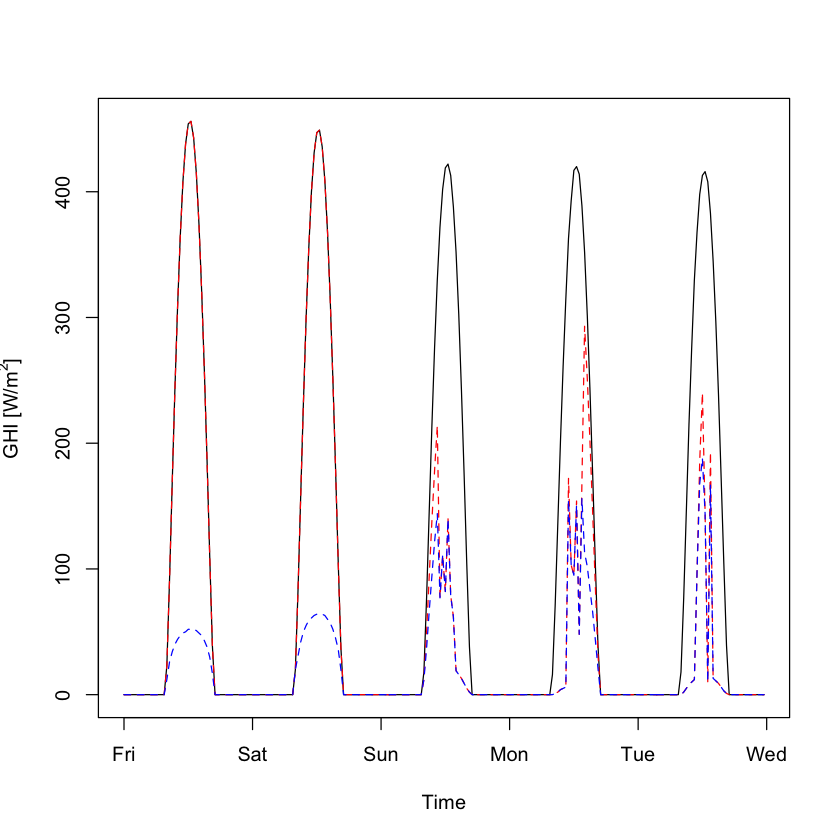

In [4]:
#extract the time and convert to POSIXct
Tm <- paste(paste(tmp$Year, tmp$Month, tmp$Day, sep = '-'), paste(tmp$Hour, tmp$Minute,sep = ':'), sep = ' ')
Tm <- as.POSIXct(Tm, format = '%Y-%m-%d %H:%M')
#Clear-sky GHI for first five days
plot(Tm[1:(48*5)], tmp$Clearsky.GHI[1:(48*5)], type = 'l', xlab = 'Time', ylab = expression(paste('GHI [W/', m^2, ']')))
lines(Tm[1:(48*5)], tmp$GHI[1:(48*5)], col = 'red', lty = 2) #GHI for the first five days
lines(Tm[1:(48*5)], tmp$DHI[1:(48*5)], col = 'blue', lty = 2) #DHI

## Getting the PSM3 data (for a list of points)